In [255]:
import csv
import json
import os
import random
import numpy as np

import mediapipe as mp

LANDMARKER_MODEL_PATH = 'models/hand_landmarker.task'
CSV_DATASET_PATH = 'datasets/HandLandmarks.csv'
IMAGE_DATASET_DIR = "E:/MyDatasets/hagrid_dataset_512"
ANNOTATIONS_DIR = "E:/MyDatasets/hagrid_dataset_annotations/train"
LABELS = ['call', 'dislike', 'fist', 'like', 'mute', 'ok', 'one', 'palm', 'peace', 'rock', 'stop', 'stop_inverted']

BaseOptions = mp.tasks.BaseOptions
HandLandmarker = mp.tasks.vision.HandLandmarker
HandLandmarkerOptions = mp.tasks.vision.HandLandmarkerOptions
VisionRunningMode = mp.tasks.vision.RunningMode


class HandDataPrepare():
    def __init__(self):
        self.NUM_SAMPLES = 5

    # Pop out a random key
    def pop_random_key(self, keys_list):
        if not keys_list:
            print("No more keys to select.")
            return None
        random_idx = random.randint(0, len(keys_list) - 1)
        return keys_list.pop(random_idx)

    
    # Check if the point (x, y) is within the bounding box.
    def is_point_in_bbox(self, x, y, bbox, margin=0.01):
        if bbox == None:
            return True
        tl_x, tl_y, width, height = bbox
        ext_tl_x = tl_x - margin
        ext_tl_y = tl_y - margin
        ext_br_x = tl_x + width + margin
        ext_br_y = tl_y + height + margin
        return ext_tl_x <= x <= ext_br_x and ext_tl_y <= y <= ext_br_y
    

    # Preprocess the hand landmark
    def pre_process_landmark(self, hand_landmarks, handedness, gesture_bboxes=None):
        landmark_list = []
        # Convert to relative coordinates
        for idx, landmark in enumerate(hand_landmarks):
            if self.is_point_in_bbox(landmark.x, landmark.y, gesture_bboxes):
                if idx == 0:
                    base_x, base_y, base_z = landmark.x - 0.5, landmark.y - 0.5, landmark.z - 0.5
                landmark_list.extend([landmark.x - base_x, landmark.y - base_y, landmark.z - base_z])
        # Convert to numpy array and add handedness
        landmark_array = np.array([handedness[0].index] + landmark_list).astype(np.float32)         # Right is 0, Left is 1
        return landmark_array


    def main(self):
        # STEP 1: Create an HandLandmarker object.
        options = HandLandmarkerOptions(
            base_options=BaseOptions(model_asset_path=LANDMARKER_MODEL_PATH),
            running_mode=VisionRunningMode.IMAGE)
        
        with HandLandmarker.create_from_options(options) as landmarker:
            with open(CSV_DATASET_PATH, 'w', newline='') as csvfile:
                csvwriter = csv.writer(csvfile)

                # STEP 2: Load the input image.
                for label in LABELS:
                    with open(os.path.join(ANNOTATIONS_DIR, f"{label}.json"), 'r') as file:
                        annotations = json.load(file)
                    annotations_keys = list(annotations.keys())
                    
                    samples_cnt = 0
                    while samples_cnt < self.NUM_SAMPLES:
                        image_name = self.pop_random_key(annotations_keys)
                        image_path = os.path.join(IMAGE_DATASET_DIR, label, f'{image_name}.jpg')
                        mp_image = mp.Image.create_from_file(image_path)

                        # STEP 3: Detect hand landmarks from the input image.
                        hand_landmarker_result = landmarker.detect(mp_image)

                        if hand_landmarker_result is not None:
                            # STEP 4: Write hand landmark into csv
                            annotations_labels = annotations[image_name]['labels']
                            annotations_bboxes = annotations[image_name]['bboxes']
                            gesture_bboxes = annotations_bboxes[annotations_labels.index(label)]

                            for hand_landmarks, handedness in zip(hand_landmarker_result.hand_landmarks,
                                                                  hand_landmarker_result.handedness):
                                landmark_array = self.pre_process_landmark(hand_landmarks, handedness, gesture_bboxes)
                                row = [LABELS.index(label)] + landmark_array.tolist()
                                
                                if len(row) == 65:
                                    csvwriter.writerow(row)
                                    samples_cnt += 1
                    print(f"Writen {samples_cnt} samples of {label}")



if __name__ == "__main__":
    body_module = HandDataPrepare()
    body_module.main()

Writen 5 samples of call
Writen 5 samples of dislike
Writen 5 samples of fist
Writen 5 samples of like
Writen 5 samples of mute
Writen 5 samples of ok
Writen 5 samples of one
Writen 5 samples of palm
Writen 5 samples of peace
Writen 5 samples of rock
Writen 5 samples of stop
Writen 5 samples of stop_inverted


23654
[Category(index=1, score=0.9646943807601929, display_name='Left', category_name='Left')]
[1.         0.5        0.5        0.5        0.44611073 0.48054177
 0.47931942 0.3995511  0.4538793  0.46204558 0.36432976 0.43346775
 0.44489807 0.32938457 0.42204565 0.4265541  0.4444493  0.39693433
 0.4737889  0.4195521  0.35944194 0.45628074 0.40543872 0.33564687
 0.44025606 0.3932022  0.31476623 0.42813703 0.48525387 0.39240336
 0.46994796 0.48815525 0.3477165  0.45810536 0.4890296  0.31939828
 0.44633716 0.48926866 0.29606044 0.4360951  0.5218134  0.4007061
 0.46353918 0.531252   0.36095542 0.45179877 0.5343402  0.33571976
 0.43920863 0.5345265  0.3132165  0.42872587 0.5538147  0.4184137
 0.45508057 0.58014643 0.39257473 0.44519758 0.5934329  0.3747455
 0.4394615  0.60041136 0.35685062 0.43449974]


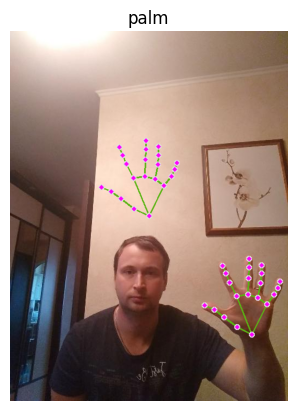

23653
[Category(index=1, score=0.9840699434280396, display_name='Left', category_name='Left')]
[1.         0.5        0.5        0.5        0.47188693 0.49179134
 0.48770958 0.4493785  0.47764665 0.47849643 0.43169522 0.46514797
 0.47033986 0.4166277  0.45601785 0.46217903 0.47717738 0.44533432
 0.4851435  0.4657427  0.42383918 0.47611964 0.45908278 0.4089761
 0.46821502 0.45455945 0.39678913 0.4623209  0.4971931  0.44255278
 0.48451805 0.4975394  0.4182878  0.47787058 0.49723893 0.40197727
 0.4718795  0.49705058 0.3887401  0.46720427 0.5157097  0.44645202
 0.4825722  0.5210675  0.42466682 0.4762951  0.52273744 0.41087356
 0.4705052  0.5231251  0.39964682 0.46609268 0.53187615 0.45535243
 0.47946382 0.54549664 0.44114468 0.47389302 0.55230623 0.43160734
 0.470918   0.55652153 0.42323637 0.46896222]


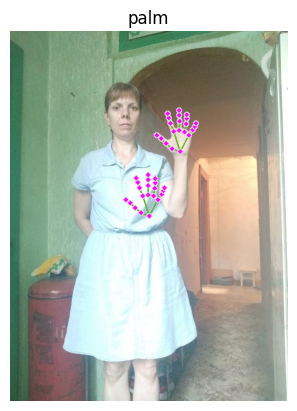

23652
[Category(index=1, score=0.9335061311721802, display_name='Left', category_name='Left')]
[1.         0.5        0.5        0.5        0.4535436  0.49049443
 0.47785226 0.407749   0.46986902 0.4639396  0.3701046  0.45360374
 0.45140937 0.340873   0.4431795  0.43907988 0.4341582  0.40878826
 0.48049393 0.41160733 0.3757462  0.46628428 0.39977092 0.35482365
 0.4532574  0.39141458 0.33618668 0.44279486 0.46445882 0.39932406
 0.47988477 0.45296657 0.36108297 0.4696435  0.4452923  0.33779645
 0.4603475  0.4388222  0.31842405 0.4521833  0.49520087 0.40163803
 0.47604215 0.49620438 0.36508393 0.46503466 0.49489748 0.34294915
 0.45529905 0.49258155 0.32365486 0.44728357 0.5241801  0.41258454
 0.4698298  0.5414584  0.38908577 0.45920208 0.55203855 0.37245703
 0.4524178  0.56052285 0.3559531  0.44708914]


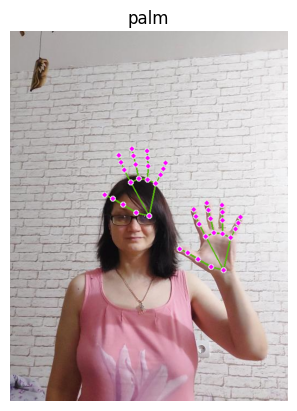

23651
[Category(index=1, score=0.9749636054039001, display_name='Left', category_name='Left')]
[1.         0.5        0.5        0.5        0.45851827 0.49239826
 0.4839986  0.4244492  0.47074133 0.47533602 0.40218183 0.45023963
 0.46772915 0.38246447 0.4348913  0.46041435 0.4414178  0.4257617
 0.4855937  0.41766787 0.39720726 0.47390905 0.40622225 0.37851086
 0.4641203  0.39908835 0.36226648 0.4566612  0.46833694 0.41741252
 0.48356715 0.45937455 0.38100016 0.4731546  0.45672667 0.35754132
 0.46437436 0.45517254 0.33898044 0.4578913  0.4961676  0.41832548
 0.47898263 0.49523532 0.38417345 0.46562925 0.4940704  0.3622435
 0.45439368 0.49280334 0.34427527 0.4472015  0.5245071  0.42480987
 0.4731893  0.54260874 0.39796567 0.46096927 0.5550059  0.37971848
 0.45313832 0.5643917  0.36291635 0.44791108]


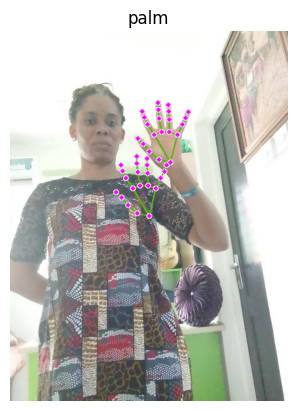

23650
[Category(index=0, score=0.9568625688552856, display_name='Right', category_name='Right')]
[0.         0.5        0.5        0.5        0.53575957 0.48170972
 0.48102915 0.5604861  0.4512068  0.47520685 0.57824075 0.4269384
 0.4712315  0.5999512  0.4166627  0.4667349  0.531791   0.4125119
 0.4814692  0.5379722  0.37836465 0.47139138 0.5408868  0.35575458
 0.46204928 0.5422564  0.3355804  0.453385   0.50526655 0.41172898
 0.47996318 0.50392604 0.37282905 0.47002685 0.5036931  0.34900367
 0.4580281  0.50249195 0.32962817 0.44795236 0.48144367 0.420326
 0.4766512  0.47129506 0.38530874 0.46301076 0.4662115  0.36275545
 0.4492398  0.46140936 0.34459418 0.43912536 0.4599591  0.43634325
 0.47191718 0.43883404 0.41376722 0.45592314 0.4252081  0.39881024
 0.445853   0.4143442  0.38479787 0.43903452]


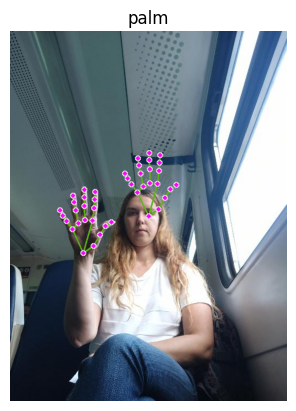

Writen 5 samples of palm


In [259]:
import cv2
import csv
import json
import os
import random
import matplotlib.pyplot as plt
import numpy as np

import mediapipe as mp
from mediapipe.framework.formats import landmark_pb2

LANDMARKER_MODEL_PATH = 'models/hand_landmarker.task'
CSV_DATASET_PATH = 'datasets/HandLandmarks.csv'
IMAGE_DATASET_DIR = "E:/MyDatasets/hagrid_dataset_512"
ANNOTATIONS_DIR = "E:/MyDatasets/hagrid_dataset_annotations/train"
LABELS = ['call', 'dislike', 'fist', 'like', 'mute', 'ok', 'one', 'palm', 'peace', 'rock', 'stop', 'stop_inverted']

BaseOptions = mp.tasks.BaseOptions
HandLandmarker = mp.tasks.vision.HandLandmarker
HandLandmarkerOptions = mp.tasks.vision.HandLandmarkerOptions
VisionRunningMode = mp.tasks.vision.RunningMode


class HandDataPrepare():
    def __init__(self):
        self.NUM_SAMPLES = 5
        self.mp_drawing = mp.solutions.drawing_utils
        self.mp_hands = mp.solutions.hands

    #############
    def draw_landmarks_on_image(self, annotated_image, hand_landmarks):
            self.mp_drawing.draw_landmarks(annotated_image, hand_landmarks,
                                        self.mp_hands.HAND_CONNECTIONS,
                                        landmark_drawing_spec=mp.solutions.drawing_utils.DrawingSpec(
                                            color=(255, 0, 255), thickness=4, circle_radius=2),
                                        connection_drawing_spec=mp.solutions.drawing_utils.DrawingSpec(
                                            color=(20, 180, 90), thickness=2, circle_radius=2)
            )
            return annotated_image
    ##############
    

    # Pop out a random key
    def pop_random_key(self, keys_list):
        if not keys_list:
            print("No more keys to select.")
            return None
        random_idx = random.randint(0, len(keys_list) - 1)
        return keys_list.pop(random_idx)

    
    # Check if the point (x, y) is within the bounding box.
    def is_point_in_bbox(self, x, y, bbox, margin=0.01):
        if bbox == None:
            return True
        tl_x, tl_y, width, height = bbox
        ext_tl_x = tl_x - margin
        ext_tl_y = tl_y - margin
        ext_br_x = tl_x + width + margin
        ext_br_y = tl_y + height + margin
        return ext_tl_x <= x <= ext_br_x and ext_tl_y <= y <= ext_br_y
    

    # Preprocess the hand landmark
    def pre_process_landmark(self, hand_landmarks, handedness, gesture_bboxes=None):
        landmark_list = []
        # Convert to relative coordinates
        for idx, landmark in enumerate(hand_landmarks):
            if self.is_point_in_bbox(landmark.x, landmark.y, gesture_bboxes):
                if idx == 0:
                    base_x, base_y, base_z = landmark.x - 0.5, landmark.y - 0.5, landmark.z - 0.5
                landmark_list.extend([landmark.x - base_x, landmark.y - base_y, landmark.z - base_z])
        # Convert to numpy array and add handedness
        landmark_array = np.array([handedness[0].index] + landmark_list).astype(np.float32)         # Right is 0, Left is 1
        return landmark_array


    def main(self):
        # STEP 1: Create an HandLandmarker object.
        options = HandLandmarkerOptions(
            base_options=BaseOptions(model_asset_path=LANDMARKER_MODEL_PATH),
            running_mode=VisionRunningMode.IMAGE)
        
        with HandLandmarker.create_from_options(options) as landmarker:
            with open(CSV_DATASET_PATH, 'w', newline='') as csvfile:
                csvwriter = csv.writer(csvfile)

                # STEP 2: Load the input image.
                # for label in LABELS:
                # for label in [random.choice(LABELS)]:       ###############
                for label in ['palm']:
                    with open(os.path.join(ANNOTATIONS_DIR, f"{label}.json"), 'r') as file:
                        annotations = json.load(file)
                    annotations_keys = list(annotations.keys())
                    
                    samples_cnt = 0
                    while samples_cnt < self.NUM_SAMPLES:
                        print(len(annotations_keys))        ####################
                        image_name = self.pop_random_key(annotations_keys)
                        image_path = os.path.join(IMAGE_DATASET_DIR, label, f'{image_name}.jpg')
                        mp_image = mp.Image.create_from_file(image_path)

                        # STEP 3: Detect hand landmarks from the input image.
                        hand_landmarker_result = landmarker.detect(mp_image)
                        # print(hand_landmarker_result)           ################


                        if hand_landmarker_result is not None:
                            # STEP 4: Write hand landmark into csv
                            annotations_labels = annotations[image_name]['labels']
                            annotations_bboxes = annotations[image_name]['bboxes']
                            gesture_bboxes = annotations_bboxes[annotations_labels.index(label)]

                            for hand_landmarks, handedness in zip(hand_landmarker_result.hand_landmarks,
                                                                  hand_landmarker_result.handedness):
                                # print(hand_landmarks)       ###########
                                print(handedness)       ############
                                landmark_array = self.pre_process_landmark(hand_landmarks, handedness, gesture_bboxes)
                                print(landmark_array)        ######################
                                row = [LABELS.index(label)] + landmark_array.tolist()
                                
                                # hand_landmarks plot ########################################################
                                hand_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
                                hand_landmarks_proto.landmark.extend([
                                    landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in hand_landmarks
                                ])
                                hand_landmarks_proto2 = landmark_pb2.NormalizedLandmarkList()
                                hand_landmarks_proto2.landmark.extend([
                                    landmark_pb2.NormalizedLandmark(x=landmark[0], y=landmark[1], z=landmark[2]) for landmark in landmark_array[1:].reshape([-1,3])
                                ])
                                annotated_image = self.draw_landmarks_on_image(cv2.imread(image_path), hand_landmarks_proto)
                                annotated_image = self.draw_landmarks_on_image(annotated_image, hand_landmarks_proto2)
                                plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
                                plt.title(label)
                                plt.axis('off')
                                plt.show()
                                # print(annotations[image_name])
                                # print(row) 
                                ################################
                                
                                if len(row) == 65:
                                    csvwriter.writerow(row)
                                    samples_cnt += 1
                    print(f"Writen {samples_cnt} samples of {label}")



if __name__ == "__main__":
    body_module = HandDataPrepare()
    body_module.main()

In [207]:
func 

NameError: name 'func' is not defined

In [1]:
#@markdown We implemented some functions to visualize the hand landmark detection results. <br/> Run the following cell to activate the functions.

import cv2
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np
import matplotlib.pyplot as plt
 
MARGIN = 10  # pixels
FONT_SIZE = 1
FONT_THICKNESS = 1
HANDEDNESS_TEXT_COLOR = (88, 205, 54) # vibrant green

def draw_landmarks_on_image2(rgb_image, detection_result):
  hand_landmarks_list = detection_result.hand_landmarks
  handedness_list = detection_result.handedness
  annotated_image = np.copy(rgb_image)

  # Loop through the detected hands to visualize.
  for idx in range(len(hand_landmarks_list)):
    hand_landmarks = hand_landmarks_list[idx]
    handedness = handedness_list[idx]

    # Draw the hand landmarks.
    hand_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    hand_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in hand_landmarks
    ])
    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      hand_landmarks_proto,
      solutions.hands.HAND_CONNECTIONS,
      solutions.drawing_styles.get_default_hand_landmarks_style(),
      solutions.drawing_styles.get_default_hand_connections_style())

    # Get the top left corner of the detected hand's bounding box.
    height, width, _ = annotated_image.shape
    x_coordinates = [landmark.x for landmark in hand_landmarks]
    y_coordinates = [landmark.y for landmark in hand_landmarks]
    text_x = int(min(x_coordinates) * width)
    text_y = int(min(y_coordinates) * height) - MARGIN

    # Draw handedness (left or right hand) on the image.
    cv2.putText(annotated_image, f"{handedness[0].category_name}",
                (text_x, text_y), cv2.FONT_HERSHEY_DUPLEX,
                FONT_SIZE, HANDEDNESS_TEXT_COLOR, FONT_THICKNESS, cv2.LINE_AA)

  return annotated_image

HandLandmarkerResult(handedness=[[Category(index=1, score=0.9919922351837158, display_name='Left', category_name='Left')]], hand_landmarks=[[NormalizedLandmark(x=0.5314213037490845, y=0.33333736658096313, z=-7.586061201436678e-08, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.48625147342681885, y=0.32424044609069824, z=-0.0022827014327049255, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.46524351835250854, y=0.30565908551216125, z=-0.005809617228806019, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.45003485679626465, y=0.28839361667633057, z=-0.011416574940085411, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.43868204951286316, y=0.2749442458152771, z=-0.017848648130893707, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.4867594838142395, y=0.26509276032447815, z=-0.0015210759593173862, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.47812604904174805, y=0.23787644505500793, z=-0.010450790636241436, visibility=0.0, presence=0.0), NormalizedLa

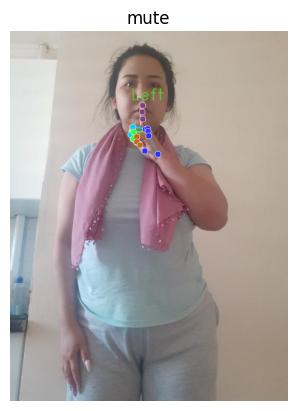

{'bboxes': [[0.16810129, 0.78975455, 0.13236671, 0.19417131], [0.41666614, 0.18111505, 0.1413608, 0.17471628]], 'user_id': '8cae201068904c1663263cc6d51bf2422088a13a17d79e0cfd4616896e73fc3d', 'labels': ['no_gesture', 'mute']}
[4, 0.5314213037490845, 0.33333736658096313, -7.586061201436678e-08, 0.48625147342681885, 0.32424044609069824, -0.0022827014327049255, 0.46524351835250854, 0.30565908551216125, -0.005809617228806019, 0.45003485679626465, 0.28839361667633057, -0.011416574940085411, 0.43868204951286316, 0.2749442458152771, -0.017848648130893707, 0.4867594838142395, 0.26509276032447815, -0.0015210759593173862, 0.47812604904174805, 0.23787644505500793, -0.010450790636241436, 0.4759645462036133, 0.21851058304309845, -0.018116449937224388, 0.4771667420864105, 0.20095989108085632, -0.025168685242533684, 0.49453645944595337, 0.2642427384853363, -0.007587821688503027, 0.4427224397659302, 0.26043522357940674, -0.021123521029949188, 0.43450719118118286, 0.27980464696884155, -0.023752365261316

In [17]:
# STEP 1: Create an HandLandmarker object.
options = HandLandmarkerOptions(
    base_options=BaseOptions(model_asset_path=LANDMARKER_MODEL_PATH),
    running_mode=VisionRunningMode.IMAGE)

with HandLandmarker.create_from_options(options) as landmarker:
    label = random.choice(LABELS)       ######
    with open(os.path.join(ANNOTATIONS_DIR, f"{label}.json"), 'r') as file:
        annotations = json.load(file)
    
    image_name = random.choice(list(annotations.keys()))
    image_path = os.path.join(IMAGE_DATASET_DIR, label, f'{image_name}.jpg')
    mp_image = mp.Image.create_from_file(image_path)

    # STEP 3: Detect hand landmarks from the input image.
    hand_landmarker_result = landmarker.detect(mp_image)
    print(hand_landmarker_result)

    # Process the classification result. In this case, visualize it.
    annotated_image = draw_landmarks_on_image(mp_image.numpy_view(), hand_landmarker_result)

    # Display the image
    plt.imshow(annotated_image)
    plt.title(label)
    plt.axis('off')  # Hide the axes
    plt.show()

    print(annotations[image_name])

    # STEP 4: Write hand landmark into csv
    annotations_labels = annotations[image_name]['labels']
    annotations_bboxes = annotations[image_name]['bboxes']
    gesture_bboxes = annotations_bboxes[annotations_labels.index(label)]

    label_dict = {label: i for i, label in enumerate(LABELS)}
    for hand_landmarks in hand_landmarker_result.hand_landmarks:
        row = [label_dict[label]]                ############ 
        for landmark in hand_landmarks:
            if body_module.is_point_in_bbox(landmark.x, landmark.y, gesture_bboxes):
                row.extend([landmark.x, landmark.y, landmark.z])
            
        print(row)